# Fake news detection using ML 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
import os
df = pd.read_excel(
     os.path.join("data/set_antrenare.xlsx"),
     engine='openpyxl',
)

In [6]:
#Modificam setul de date pentru cel de jos schimband subcategory in subject
df = df.rename(columns = {'subcategory': 'subject'}, inplace = False)
df["subject"].replace({"false news": "Covid19", "partially false": "Covid19", "true": "Covid19"}, inplace=True)
df["label"].replace({0: "fake", 1: "true"}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,title,text,subject,label
0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,Covid19,fake
1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,Covid19,true
2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,Covid19,true
3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",Covid19,fake
4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,Covid19,fake


In [7]:
# Add flag to track fake and real
fake['label'] = 'fake'
true['label'] = 'true'

In [8]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,fake


In [10]:
data = pd.concat([data, df]).reset_index(drop = True)
data.shape

(48017, 4)

In [11]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [12]:
data.head()

,title,text,subject,label
0,Boiler Room EP #83 – Wouldn’t It Be Nice…,Tune in to the Alternate Current Radio Network...,US_News,fake
1,Democrats want 'major role' for Sanders: Reute...,NEW YORK (Reuters) - Bernie Sanders may have l...,politicsNews,true
2,CHILLING: How America Looks After 8 Long Years...,The shocking truth about how close we are to b...,Government News,fake
3,WOW! MILWAUKEE SCHOOL OF ENGINEERING Professor...,Socialist indoctrination starts in Kindergarte...,politics,fake
4,LOL! ONE HILARIOUS CARTOON Perfectly Illustrat...,Watching sports on TV or going to a football s...,left-news,fake


In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,label
0,Tune in to the Alternate Current Radio Network...,US_News,fake
1,NEW YORK (Reuters) - Bernie Sanders may have l...,politicsNews,true
2,The shocking truth about how close we are to b...,Government News,fake
3,Socialist indoctrination starts in Kindergarte...,politics,fake
4,Watching sports on TV or going to a football s...,left-news,fake


In [14]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,label
0,tune in to the alternate current radio network...,US_News,fake
1,new york (reuters) - bernie sanders may have l...,politicsNews,true
2,the shocking truth about how close we are to b...,Government News,fake
3,socialist indoctrination starts in kindergarte...,politics,fake
4,watching sports on tv or going to a football s...,left-news,fake


In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
# Check
data.head()

,text,subject,label
0,tune in to the alternate current radio network...,US_News,fake
1,new york reuters bernie sanders may have lost...,politicsNews,true
2,the shocking truth about how close we are to b...,Government News,fake
3,socialist indoctrination starts in kindergarte...,politics,fake
4,watching sports on tv or going to a football s...,left-news,fake


In [17]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mihai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data.head()

,text,subject,label
0,tune alternate current radio network acr anoth...,US_News,fake
1,new york reuters bernie sanders may lost bid b...,politicsNews,true
2,shocking truth close becoming oneparty fascist...,Government News,fake
3,socialist indoctrination starts kindergarten r...,politics,fake
4,watching sports tv going football stadium watc...,left-news,fake


## Basic data exploration

subject
Covid19             3119
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


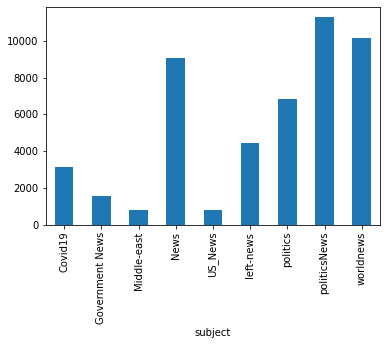

In [19]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
fake    24539
true    23478
Name: text, dtype: int64


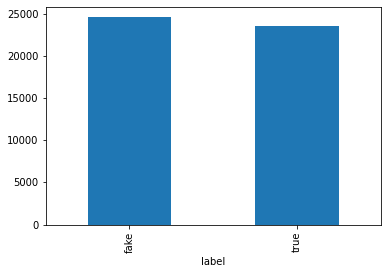

In [20]:
# How many fake and real articles?
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

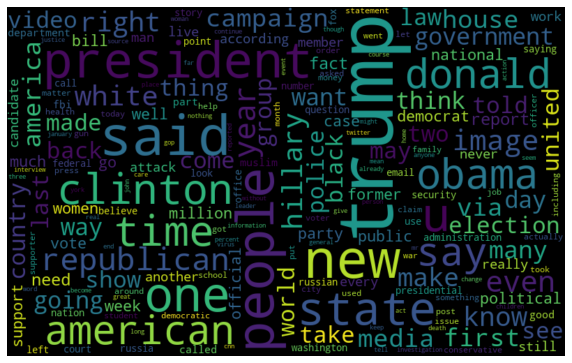

In [21]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["label"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

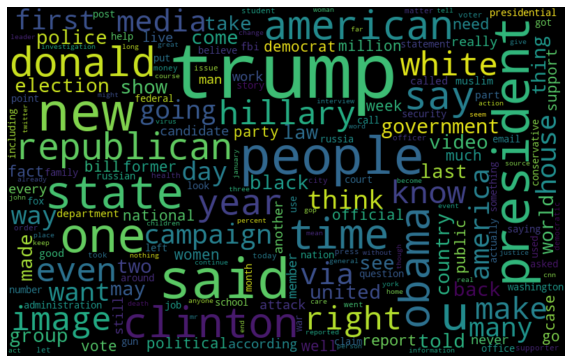

In [22]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["label"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

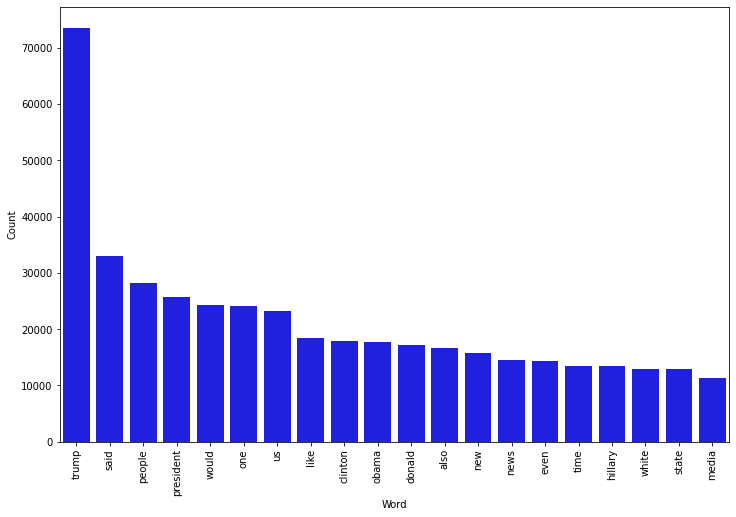

In [24]:
# Most frequent words in fake news
counter(data[data["label"] == "fake"], "text", 20)

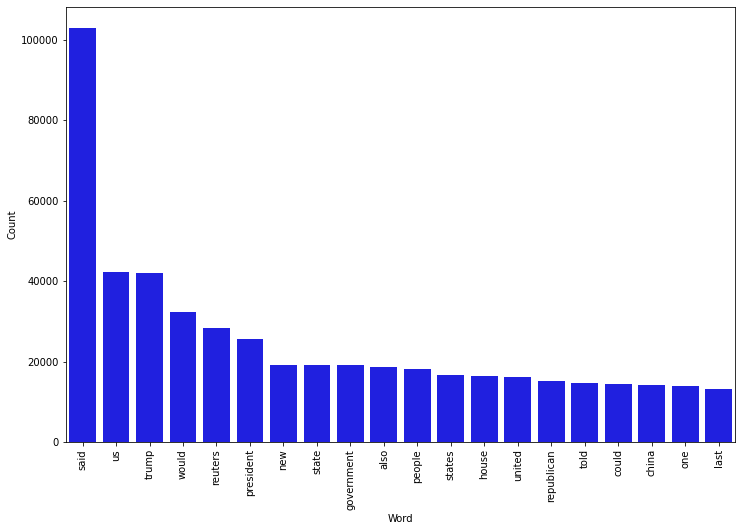

In [25]:
# Most frequent words in real news
counter(data[data["label"] == "true"], "text", 20)

## Modeling

In [26]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=42)

In [28]:
covid19ID = []
covid19TrainID = []

for index, row in data.iterrows():
    if row['subject'] == "Covid19":
        covid19ID.append(index)
        
total = len(covid19ID)
print("Numarul total de stiri COVID din setul de date este", total)

for index, value in X_train.items():
    for i in covid19ID:
        if (index == i):
            covid19TrainID.append(i)
            
trainTotal = len(covid19TrainID)

print("Numarul total de stiri COVID din setul de antrenare este", trainTotal)

print("Numarul total de stiri COVID din setul de test", total - trainTotal)

#din tot setul imi selecteaza id-urile COVID
#din setul de train imi selecteaza id-urule COVID
#Test = Set - Train (nr)

Numarul total de stiri COVID din setul de date este 3119
Numarul total de stiri COVID din setul de antrenare este 2510
Numarul total de stiri COVID din setul de test 609


# **Naive Bayes**




In [29]:
dct = dict()
dct_p = dict()
dct_r = dict()
dct_f1 = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Naive Bayes'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Naive Bayes'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Naive Bayes'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 92.99%
precission: 89.91%
recall: 96.35%
F1 score: 93.02%
              precision    recall  f1-score   support

        fake       0.96      0.90      0.93      4951
        true       0.90      0.96      0.93      4653

    accuracy                           0.93      9604
   macro avg       0.93      0.93      0.93      9604
weighted avg       0.93      0.93      0.93      9604



Confusion matrix, without normalization


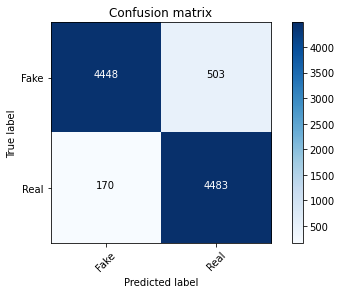

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [31]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Logistic Regression'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Logistic Regression'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Logistic Regression'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.42%
precission: 96.77%
recall: 97.94%
F1 score: 97.35%
              precision    recall  f1-score   support

        fake       0.98      0.97      0.97      4951
        true       0.97      0.98      0.97      4653

    accuracy                           0.97      9604
   macro avg       0.97      0.97      0.97      9604
weighted avg       0.97      0.97      0.97      9604



Confusion matrix, without normalization


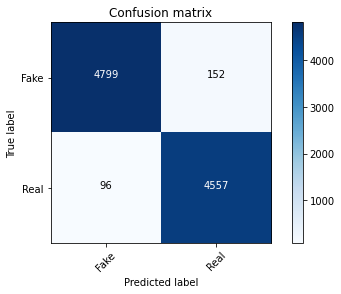

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Decision Tree'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Decision Tree'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Decision Tree'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.9%
precission: 97.71%
recall: 97.96%
F1 score: 97.83%
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      4951
        true       0.98      0.98      0.98      4653

    accuracy                           0.98      9604
   macro avg       0.98      0.98      0.98      9604
weighted avg       0.98      0.98      0.98      9604



Confusion matrix, without normalization


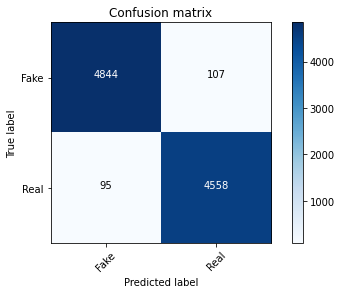

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Random Forest'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Random Forest'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Random Forest'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.18%
precission: 95.89%
recall: 98.39%
F1 score: 97.13%
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      4951
        true       0.96      0.98      0.97      4653

    accuracy                           0.97      9604
   macro avg       0.97      0.97      0.97      9604
weighted avg       0.97      0.97      0.97      9604



Confusion matrix, without normalization


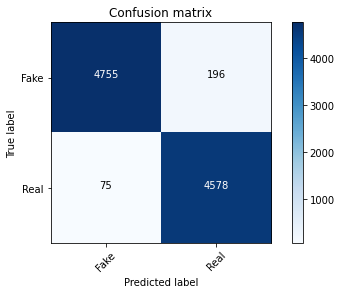

In [36]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [37]:
from sklearn import svm
import joblib

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['SVM'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['SVM'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['SVM'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

#Saving the model
filename = 'finalized_model.sav'
joblib.dump(model, filename)

accuracy: 98.22%
precission: 97.66%
recall: 98.69%
F1 score: 98.17%
              precision    recall  f1-score   support

        fake       0.99      0.98      0.98      4951
        true       0.98      0.99      0.98      4653

    accuracy                           0.98      9604
   macro avg       0.98      0.98      0.98      9604
weighted avg       0.98      0.98      0.98      9604



['finalized_model.sav']

Confusion matrix, without normalization


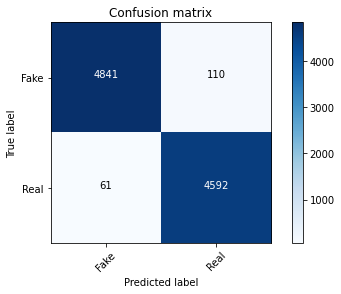

In [38]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **KNN**

In [39]:
from sklearn.neighbors import KNeighborsClassifier
## **KNN**
#Create a svm Classifier
knn = KNeighborsClassifier(n_neighbors = 3)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', knn)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['KNN'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['KNN'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['KNN'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['KNN'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 65.7%
precission: 95.45%
recall: 30.67%
F1 score: 46.42%
              precision    recall  f1-score   support

        fake       0.60      0.99      0.75      4951
        true       0.95      0.31      0.46      4653

    accuracy                           0.66      9604
   macro avg       0.78      0.65      0.61      9604
weighted avg       0.77      0.66      0.61      9604



Confusion matrix, without normalization


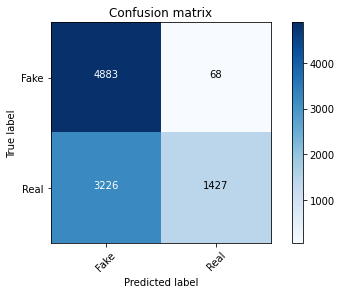

In [40]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **BERT**

In [ ]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_text = X_train
temp_text = X_test
train_labels = y_train
temp_labels = y_test

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 64

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding = 'max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding = 'max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding = 'max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
temp_list = train_labels.tolist()

# dictionary that maps integer to its string value 
label_dict_train = {}

# list to store integer labels 
int_labels_train = []

for i in range(len(temp_list)):
    label_dict_train[i] = temp_list[i]
    int_labels_train.append(i)
    
temp_list2 = val_labels.tolist()

# dictionary that maps integer to its string value 
label_dict_var = {}

# list to store integer labels 
int_labels_var = []

for i in range(len(temp_list2)):
    label_dict_var[i] = temp_list[i]
    int_labels_var.append(i)
    
temp_list3 = test_labels.tolist()

# dictionary that maps integer to its string value 
label_dict_test = {}

# list to store integer labels 
int_labels_test = []

for i in range(len(temp_list3)):
    label_dict_train[i] = temp_list[i]
    int_labels_train.append(i)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(int_labels)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(int_labels_var)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(int_labels_test)

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
      # dropout layer
        self.dropout = nn.Dropout(0.1)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

      # output layer
        x = self.fc2(x)
      
      # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

    # clear previously calculated gradients 
        model.zero_grad()        

    # get model predictions for the current batch
        preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

    # add on to the total loss
        total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
        loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
        optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
        total_preds.append(preds)

  # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
  
  # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
    total_preds = []

  # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

    # deactivate autograd
        with torch.no_grad():
      
      # model predictions
            preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

  # compute the validation loss of the epoch
        avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
        total_preds  = np.concatenate(total_preds, axis=0)

        return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x1e5061d3580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

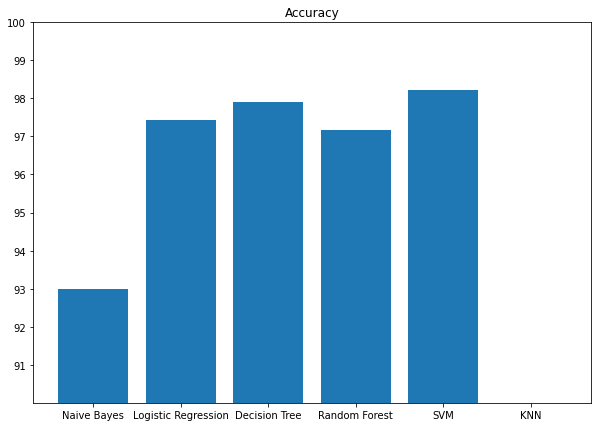

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.title('Accuracy')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x1e506cc9610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

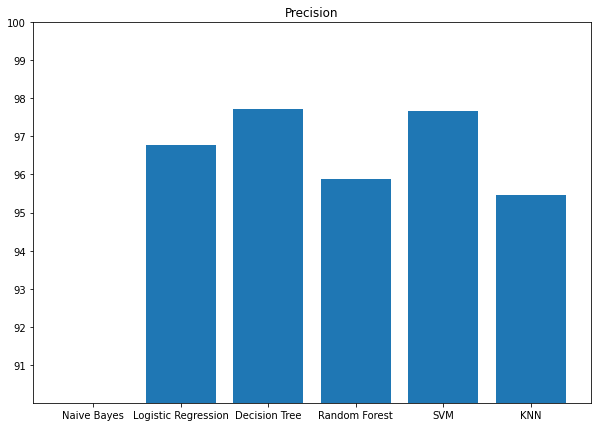

In [42]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_p.keys()),list(dct_p.values()))
plt.title('Precision')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x1e525efc760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

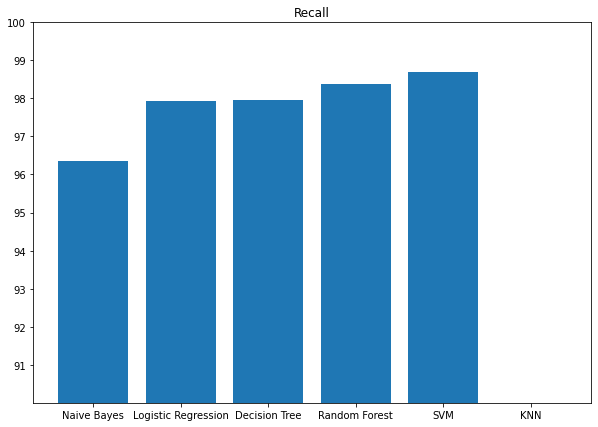

In [43]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_r.keys()),list(dct_r.values()))
plt.title('Recall')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x1e50a267850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

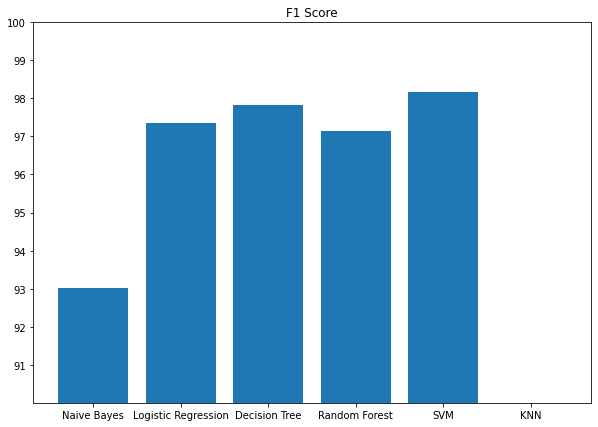

In [44]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_f1.keys()),list(dct_f1.values()))
plt.title('F1 Score')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))